In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
from tqdm import trange
import gzip
import requests as r

In [2]:
DOWNLOAD = False
urls = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
       'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
       'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
       'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

def download(urls):
    for url in urls:
        buf = r.get(url).content
        with open('./downloads/' + url.split('/')[-1], 'wb') as f:
            f.write(bytearray(buf))

if DOWNLOAD:
    download(urls)

paths = {
    'test_imgs': 't10k-images-idx3-ubyte.gz',
    'test_labels': 't10k-labels-idx1-ubyte.gz',
    'train_imgs': 'train-images-idx3-ubyte.gz',
    'train_labels': 'train-labels-idx1-ubyte.gz'
}
for path in paths:
    paths[path] = './downloads/' + paths[path]

try:
    for _, arr in data.items():
        print(arr.shape)
except NameError:
    data = dict()
    for name, path in paths.items():
        with gzip.open(path) as f:
            if 'imgs' in name:
                data[name] = np.frombuffer(f.read(), 'B', offset=16).reshape((-1, 1, 28, 28))
            else:
                data[name] = np.frombuffer(f.read(), 'B', offset=8)

In [3]:
test_imgs = data['test_imgs']
test_labels = data['test_labels']
train_imgs = data['train_imgs']
train_labels = data['train_labels']

In [4]:
class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.hid = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    def forward(self, x):
        return self.hid(x)

Loss= 0.03, Acc= 1.00:  62%|███████████████████████████████████████████████████▉                                | 3093/5000 [00:03<00:01, 1011.30it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss= 0.17, Acc= 0.97: 100%|████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1029.87it/s]


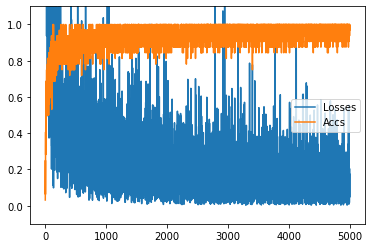

In [5]:
model = BobNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0)
epochs = 5000
BS = 32

losses, accs  = [], []
for i in (t := trange(epochs)):
    samp = np.random.randint(0, train_imgs.shape[0], size=BS)
    X = torch.tensor(train_imgs[samp]).float()
    Y = torch.tensor(train_labels[samp]).long()
    
    optimizer.zero_grad()
    pred = model(X)
    loss = loss_fn(pred, Y)
    Y_hat = torch.argmax(pred, dim=1)
    acc = (Y_hat == Y).float().mean()
    loss.backward()
    optimizer.step()
    loss, acc = loss.item(), acc.item()
    losses.append(loss)
    accs.append(acc)
    t.set_description(f'Loss={loss: .2f}, Acc={acc: .2f}')

plt.ylim(-.1, 1.1)
plt.plot(losses, label='Losses')
plt.plot(accs, label='Accs')
plt.legend()
plt.show()

In [6]:
def layer_init(size):
    return np.random.uniform(-1, 1, size=size)/np.sqrt(np.prod(size))

class Linear():
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.weight = layer_init((out_dim, in_dim))
        self.bias = layer_init((out_dim))

        self.weight_grad = np.empty((out_dim))
        self.bias_grad = np.empty((out_dim))

    def forward(self, x):
        return np.dot(self.weight, x) + self.bias

    def diff_B(self, x):
        return 1
    def diff_W(self, x):
        grad = np.empty(self.weight.shape + x.shape)
        for i in range(grad.shape[0]):
            for j in range(grad.shape[1]):
                grad[i,j] = x
        return grad.reshape((self.weight.shape[0], -1))
    def diff_X(self, x):
        return self.weight
    def __call__(self, x):
        return self.forward(x)
    def __str__(self):
        return f'Linear(in_features={self.in_dim}, out_features={self.out_dim})'
    __repr__=__str__

class ReLU():
    def forward(self, x):
        x[x < 0] = 0
        return x

    def diff(self, x):
        return (x < 0) * 1

    def __call__(self, x):
        return self.forward(x)
    def __str__(self):
        return 'ReLU()'
    __repr__=__str__
        
class Flatten():
    def forward(self, x):
        return x.reshape((-1))
    
    def __call__(self, x):
        return self.forward(x)
    def __str__(self):
        return 'Flatten()'
    __repr__=__str__

class Sequential():
    def __init__(self, *args):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def __call__(self, x):
        return self.forward(x)
    def __getitem__(self, i):
        return self.layers[i]
    def __str__(self):
        str = 'Sequentail(\n'
        for i, layer in enumerate(self.layers):
            str += f'  ({i}): {repr(layer)}\n'
        str += ')'
        return str
    __repr__=__str__

In [7]:
model.hid[1].weight

Parameter containing:
tensor([[ 0.0295,  0.0142,  0.0141,  ...,  0.0113,  0.0209, -0.0047],
        [-0.0305,  0.0133,  0.0012,  ..., -0.0324, -0.0133,  0.0245],
        [-0.0221,  0.0180,  0.0188,  ..., -0.0104,  0.0352,  0.0098],
        ...,
        [ 0.0210,  0.0038, -0.0067,  ...,  0.0171, -0.0321,  0.0151],
        [ 0.0331, -0.0316, -0.0219,  ...,  0.0030,  0.0206,  0.0254],
        [-0.0107,  0.0338, -0.0274,  ..., -0.0090, -0.0250,  0.0259]],
       requires_grad=True)

In [8]:
def softmax(Z):
    """Softmax: T[Nx1] -> T[Nx1]"""
    return np.exp(Z) / np.sum(np.exp(Z))
def diff_softmax(Z):
    """J_Softmax: T[Nx1] -> T[NxN]"""
    n = Z.shape[0]
    jac = np.empty((n, n))
    softmax_z = softmax(Z)
    for i in range(n):
        for j in range(n):
            jac[i][j] = softmax_z[i] * ((i == j) - softmax_z[j])
    return jac

def cross_entropy(y_hat, y):
    """CE: T[Nx1] x T[Nx1] -> T[1]"""
    return -np.sum(y*np.log(y_hat))
def diff_cross_entropy(y_hat, y):
    """G_CE: T[Nx1] x T[Nx1] -> T[Nx1]"""
    grad = np.empty(y_hat.shape)
    for i in range(y_hat.shape[0]):
        grad[i] = - y[i] / y_hat[i]
    return grad

def cross_entropy_loss(Y_hat, Y):
    """CEL: T[Nx1] x T[Nx1] -> T[1]"""
    return cross_entropy(softmax(Y_hat), Y)
def diff_cross_entropy_loss(Y_hat, Y):
    """G_CEL: T[Nx1] x T[Nx1] -> T[Nx1]"""
#     return np.matmul(diff_softmax(Y_hat), diff_cross_entropy(softmax(Y_hat), Y))
    return (softmax(Y_hat) - Y)

class RawNet():
    def __init__(self):
        self.hid = Sequential(
            Flatten(),
            Linear(28*28, 128),
            ReLU(),
            Linear(128, 10),
        )
    def forward(self, x):
        return self.hid(x)
    def __call__(self, x):
        return self.forward(x)
raw_model = RawNet()
print(raw_model.hid)
# raw_model.hid[1].weight = model.hid[1].weight.clone().detach().numpy()
# raw_model.hid[1].bias = model.hid[1].bias.clone().detach().numpy()
# raw_model.hid[3].weight = model.hid[3].weight.clone().detach().numpy()
# raw_model.hid[3].bias = model.hid[3].bias.clone().detach().numpy()

Sequentail(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=128)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10)
)


In [9]:
def fill_grads(Y_hat, y, X, model):
    Y = np.zeros(10)
    Y[y] = 1
    X = model.hid[0](X)
    Z = model.hid[1](X)
    H = model.hid[2](Z)

    d_cel = diff_cross_entropy_loss(Y_hat, Y)
    model.hid[3].weight_grads = np.outer(d_cel, H)
    model.hid[3].bias_grads = d_cel.T.dot(model.hid[3].diff_B(H))

    d_relu = d_cel.T.dot(raw_model.hid[3].diff_X(H)) * model.hid[2].diff(Z)
    model.hid[1].weight_grads = np.outer(d_relu, X)
    model.hid[1].bias_grads = d_relu.dot(model.hid[1].diff_B(X))

In [10]:
def apply_grads(model, lr=1e-3):
    model.hid[3].weight -= model.hid[3].weight_grads * lr
    model.hid[3].bias -= model.hid[3].bias_grads * lr
    model.hid[1].weight -= model.hid[1].weight_grads * lr
    model.hid[1].bias -= model.hid[1].bias_grads * lr

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2380.42it/s]


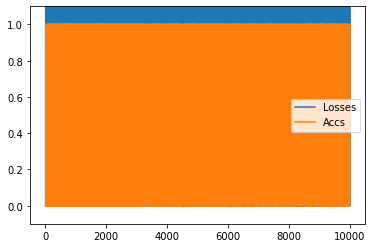

1.0

In [24]:
BS = 1
raw_model = RawNet()
losses, accs = [], []

for _ in trange(10000):
    samp = np.random.randint(0, test_imgs.shape[0], size=BS)
    X = train_imgs[samp]
    Y = train_labels[samp]
    for i, (x, y) in enumerate(zip(X, Y)):
        pred = raw_model(x)
        loss = cross_entropy_loss(pred, y)
        Y_hat = np.argmax(pred)
        acc = (Y_hat == Y).mean()
        fill_grads(pred, y, x, raw_model)
        apply_grads(raw_model, lr=1e-3)
        losses.append(loss)
        accs.append(acc)
plt.ylim(-.1, 1.1)
plt.plot(losses, label='Losses')
plt.plot(accs, label='Accs')
plt.legend()
plt.show()
np.array(accs)[-100].mean()

In [25]:
np.array(accs)[-100:].mean()

0.87

np.argmax(raw_model(test_imgs[0].reshape((28,28))))

4

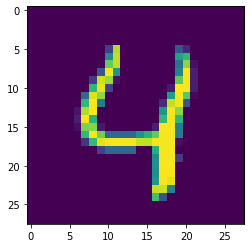

In [26]:
plt.imshow(test_imgs[4].reshape((28,28)))
np.argmax(raw_model(test_imgs[4].reshape((-1,1,28,28))))